In [ ]:
from random import randint
import os
import math
import random
import gc
import pickle
import time
import torch
from numba import jit, cuda
import pandas as pd
import numpy as np
import json
import csv
import copy
import psutil

In [ ]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import random
import os
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten,Embedding
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')
import math
import random
import gc
import pickle
import pandas as pd
import numpy as np
import re
import string
from os import listdir
from os.path import isfile,join
from tensorflow.keras.utils import to_categorical


# Making X-Y Pairs from File

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
X=np.load('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/X_id_without_sen_shuffle.npy')
Y=np.load('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/Y_id_without_sen_shuffle.npy').tolist()
one_h=np.load('/content/drive/MyDrive/Transformer_Experiments/OneHotEncoded.npy')

In [ ]:
X.shape

(11626899, 20)

In [ ]:
for i in range(len(Y)):
  for j,value in enumerate(Y[i]):
    Y[i][j]=one_h[value]
del one_h
gc.collect()

50

In [ ]:
file1=open('/content/drive/MyDrive/Transformer_Experiments/final_stopwords.txt')
stopwords=[]
for lines in file1.readlines():
  stopwords.append(lines[:-1])

In [ ]:
convert_file=open('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/wordtoid_without_sen_shuffle.json', 'r')
word2id=json.load(convert_file)
convert_file.close()
id2word=np.load('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/idtoword_without_sen_shuffle.npy')

In [ ]:
stopid=[]
for s in stopwords:
  if s in word2id:
    stopid.append(word2id[s])
  else:
    print(s)

In [ ]:
len(stopid)

235

In [ ]:
print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 35.4


Major code for below two sections('Bahadanu' + 'Encoder-Decoder-withattention') was taken from **Murat Karakaya Akademi**'s publicly available colab file.

# Bhanandu attention
Implemening Bhanandu attention layer

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units, verbose=0):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    self.verbose= verbose

  def call(self, query, values):
    if self.verbose:
      print('\n******* Bahdanau Attention STARTS******')
      print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
      print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    if self.verbose:
      print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    if self.verbose:
      print('score: (batch_size, max_length, 1) ',score.shape)
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    if self.verbose:
      print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    if self.verbose:
      print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    if self.verbose:
      print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
      print('\n******* Bahdanau Attention ENDS******')
    return context_vector, attention_weights


# Encoder-Decoder-withattention
function_name: framing_model

In [ ]:
def framing_model(n_features,latentSpaceDimension=128,batch_size=100,n_timesteps_in=10,n_timesteps_out=10,loss_function='categorical_crossentropy',verbose=0):
  if verbose:
    print('***** Model Hyper Parameters *******')
    print('latentSpaceDimension: ', latentSpaceDimension)
    print('batch_size: ', batch_size)
    print('sequence length: ', n_timesteps_in)
    print('n_features: ', n_features)

    print('\n***** TENSOR DIMENSIONS *******')

  # The first part is encoder
  encoder_inputs = Input(shape=(n_timesteps_in), name='encoder_inputs')
  encoder_embedding=Embedding(input_dim=n_features, output_dim=300)
  encoder_lstm = LSTM(latentSpaceDimension,return_sequences=True, return_state=True,  name='encoder_lstm')
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))

  if verbose:
    print ('Encoder output shape: (batch size, sequence length, latentSpaceDimension) {}'.format(encoder_outputs.shape))
    print ('Encoder Hidden state shape: (batch size, latentSpaceDimension) {}'.format(encoder_state_h.shape))
    print ('Encoder Cell state shape: (batch size, latentSpaceDimension) {}'.format(encoder_state_c.shape))
  # initial context vector is the states of the encoder
  encoder_states = [encoder_state_h, encoder_state_c]
  if verbose:
    print(encoder_states)
  # Set up the attention layer
  attention= BahdanauAttention(latentSpaceDimension, verbose=verbose)


  # Set up the decoder layers
  decoder_lstm = LSTM(latentSpaceDimension,  return_state=True, name='decoder_lstm')
  decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

  all_outputs = []

  # 1 initial decoder's input data
  # Prepare initial decoder input data that just contains the start character 
  # Note that we made it a constant one-hot-encoded in the model
  # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
  # one-hot encoded zero(0) is the start symbol
  inputs = np.zeros((batch_size, 1, n_features))
  inputs[:, 0, 0] = 1 


  # 2 initial decoder's state
  # encoder's last hidden state + last cell state
  decoder_outputs = encoder_state_h
  states = encoder_states
  if verbose:
    print('initial decoder inputs: ', inputs.shape)

  # decoder will only process one time step at a time.
  for _ in range(n_timesteps_out):

      # 3 pay attention
      # create the context vector by applying attention to 
      # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
      if verbose:
        print("Attention context_vector: (batch size, units) {}".format(context_vector.shape))
        print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
        print('decoder_outputs: (batch_size,  latentSpaceDimension) ', decoder_outputs.shape )
      context_vector = tf.expand_dims(context_vector, 1)
      if verbose:
        print("context_vector = tf.expand_dims(context_vector, 1)")
        print('Reshaped context_vector: ', context_vector.shape )
        print("inputs.shape {}".format(inputs.shape))
      # 4. concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)
      if verbose:
        print('After concat([context_vector;inputs]) inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )

      # 5. passing the concatenated vector to the LSTM
      # Run the decoder on one timestep with attended input and previous states
      decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
  #    print(state_h.shape)
      outputs = decoder_dense(decoder_outputs)
      # 6. Use the last hidden state for prediction the output
      # save the current prediction
      # we will concatenate all predictions later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      # 7. Reinject the output (prediction) as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]


  # 8. After running Decoder for max time steps
  # we had created a predition list for the output sequence
  # convert the list to output array by Concatenating all predictions 
  # such as [batch_size, timesteps, features]
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  # 9. Define and compile model 
  model_encoder_decoder_Bahdanau_Attention = Model(encoder_inputs, 
                                                  decoder_outputs, name='model_encoder_decoder')
  model_encoder_decoder_Bahdanau_Attention.compile(optimizer='rmsprop', 
                                                  loss=loss_function, metrics=['accuracy'])
  return model_encoder_decoder_Bahdanau_Attention

# New Section

In [ ]:
batch_size=1024
enc_dec_attention=framing_model(n_features=Y[0][0].shape[0],
                      latentSpaceDimension=128,
                      batch_size=batch_size,
                      n_timesteps_in=20,
                      n_timesteps_out=1)

In [ ]:
enc_dec_attention.summary()

Model: "model_encoder_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 20, 300)      3230100     ['encoder_inputs[0][0]']         
                                                                                                  
 encoder_lstm (LSTM)            [(None, 20, 128),    219648      ['embedding_4[0][0]']            
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                              

In [ ]:
print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 35.0


In [ ]:
a=len(X)/55296

In [ ]:
int(a-a*0.1-2)

187

In [ ]:
validation_X=X[55296*int(a-a*0.1-2):55296*int(a-a*0.1-2)+10240]
validation_Y=np.array(Y[55296*int(a-a*0.1-2):55296*int(a-a*0.1-2)+10240])

In [ ]:
p=json.loads('{"validation_accuracies_upto_i-th_sample": [0.1671875, 0.20380859375, 0.2220703125, 0.234765625, 0.24072265625, 0.24775390625, 0.25322265625, 0.2587890625, 0.2625, 0.26240234375]}')
len(p['validation_accuracies_upto_i-th_sample'])

In [ ]:
enc_dec_attention.load_weights('/content/drive/MyDrive/Enc-dec_attention/20,1,X,Y/enc-dec20,1,made from enc-dec-attention 27-4-2022 9:10PM /weights_enc_dec_attention')

In [ ]:
enc_dec_attention.evaluate(validation_X,validation_Y,batch_size=1024)

10/10 [==============================] - 7s 79ms/step - loss: 3.9271 - accuracy: 0.3516


[3.927082872390747, 0.3515625]

In [ ]:
p={}
p['validation_accuracies_upto_i-th_sample']=[]


In [ ]:
segment=0

In [ ]:
for i in range(int(a-a*0.1-2)):
#  segment=random.randint(20,300)
  l=55296*segment
  u=55296*(segment+1)
  X_10_1=X[l:u]
  Y_10_1=np.array(Y[l:u])
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)
  history=enc_dec_attention.fit(X_10_1,Y_10_1,batch_size=batch_size,epochs=30,validation_data=(validation_X,validation_Y),callbacks=[callback])
#  tf.keras.optimizers.Adam(learning_rate=0.001)
  enc_dec_attention.save_weights("/content/drive/MyDrive/Enc-dec_attention/20,1,X,Y/weights_enc_dec_attention")
  p['validation_accuracies_upto_i-th_sample'].append(max(history.history['val_accuracy']))
  ar_file=open('/content/drive/MyDrive/Enc-dec_attention/20,1,X,Y/val_acc.json', 'w')
  json.dump(p,ar_file)
  ar_file.seek(0)
  ar_file.close()
  gc.collect()
  del X_10_1
  del Y_10_1
  del history
  gc.collect()
  print('RAM memory % used:', psutil.virtual_memory()[2])
  print(color.BOLD+"cou={},i={} done".format(segment,i+1)+color.END)
  segment+=1
  if segment<int(a-a*0.1-2):
    continue
  else:
    break

Epoch 1/30
54/54 [==============================] - 12s 165ms/step - loss: 7.1902 - accuracy: 0.0322 - val_loss: 6.8139 - val_accuracy: 0.0334
Epoch 2/30
54/54 [==============================] - 7s 125ms/step - loss: 6.7293 - accuracy: 0.0386 - val_loss: 6.7749 - val_accuracy: 0.0485
Epoch 3/30
54/54 [==============================] - 7s 125ms/step - loss: 6.5536 - accuracy: 0.0468 - val_loss: 6.6422 - val_accuracy: 0.0510
Epoch 4/30
54/54 [==============================] - 7s 124ms/step - loss: 6.3819 - accuracy: 0.0524 - val_loss: 6.5642 - val_accuracy: 0.0567
Epoch 5/30
54/54 [==============================] - 7s 124ms/step - loss: 6.2156 - accuracy: 0.0633 - val_loss: 6.4549 - val_accuracy: 0.0648
Epoch 6/30
54/54 [==============================] - 7s 124ms/step - loss: 6.0438 - accuracy: 0.0724 - val_loss: 6.3359 - val_accuracy: 0.0712
Epoch 7/30
54/54 [==============================] - 7s 135ms/step - loss: 5.8841 - accuracy: 0.0797 - val_loss: 6.2560 - val_accuracy: 0.0780
Epoch

In [ ]:
testing_l=int(a-a*0.1-2)*552
testing_u=(int(a)-1)*552

In [ ]:
#Making Test Dataset
Testing_Y=[]
for i in range(128):
  segment=random.randint(testing_l,testing_u)
  if i==0:
    Testing_X=X[80*segment:80*(segment+1)]
  else:
    Testing_X=np.vstack((Testing_X,X[80*segment:80*(segment+1)]))
#  print(i)
  Testing_Y+=Y[80*segment:80*(segment+1)]

In [ ]:
#Test DataSet Accuracy
enc_dec_attention.evaluate(Testing_X,np.array(Testing_Y),batch_size=1024)

10/10 [==============================] - 1s 74ms/step - loss: 3.9649 - accuracy: 0.3471


[3.9648939847946165, 0.3470703125]

In [ ]:
nstop_val_x=[]
nstop_val_y=[]
stop_val_x=[]
stop_val_y=[]
for i in range(len(validation_Y)):
  if argmax(validation_Y[i][0]) not in stopid:
    nstop_val_x.append(validation_X[i])
    nstop_val_y.append(validation_Y[i])
  else:
    stop_val_x.append(validation_X[i])
    stop_val_y.append(validation_Y[i])

In [ ]:
nstop_val_x=nstop_val_x[:int((len(nstop_val_x)/1024))*1024]
nstop_val_y=nstop_val_y[:int((len(nstop_val_y)/1024))*1024]
stop_val_x=stop_val_x[:int((len(stop_val_x)/1024))*1024]
stop_val_y=stop_val_y[:int((len(stop_val_y)/1024))*1024]

In [ ]:
len(nstop_val_x),len(stop_val_x)

(5120, 4096)

In [ ]:
#Stopwords Accuracy
enc_dec_attention.evaluate(np.array(stop_val_x),np.array(stop_val_y),batch_size=1024)
#Non-Stopwords Accuracy
enc_dec_attention.evaluate(np.array(nstop_val_x),np.array(nstop_val_y),batch_size=1024)

5/5 [==============================] - 0s 73ms/step - loss: 5.0383 - accuracy: 0.2742


[5.03831033706665, 0.27421875]

In [ ]:
def printing_outputs(model,X,Y,no_words):
  pred=model.predict(X,batch_size=1024)
  Output=[]
  Input=[]
  correct=0
  no=0
  for j in range(len(pred)):
    sentences_i=[]
    sentences_o=[]
    s=one_hot_decode(pred[j],no_words)
    for i in range(len(s)):
      no+=1
      if argmax(Y[j][i]) in s[i]:
        correct+=1
      sentences_o.append(id2word[s[i]])
    for i in X[j]:
      sentences_i.append(id2word[i])
    Output.append(sentences_o)
    Input.append(sentences_i)
#  for i in range(len(X)):
#    print(Input[i],Output[i])
  return correct/no
def one_hot_decode(encoded_seq,no_words):
	return [np.argpartition(vector, -no_words)[-no_words:] for vector in encoded_seq]

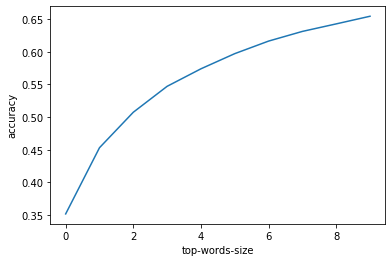

In [ ]:
#accuracies vs top 'n' words
n_acc={}
n_acc['accuracies']=[printing_outputs(enc_dec_attention,validation_X[:10240],validation_Y[:10240],i+1) for i in range(10)] 
plt.plot(n_acc['accuracies'])
plt.ylabel('accuracy')
plt.xlabel('top-words-size')
plt.show()

In [ ]:
n_acc

{'accuracies': [0.3515625,
  0.45302734375,
  0.507421875,
  0.54716796875,
  0.5740234375,
  0.597265625,
  0.61650390625,
  0.63134765625,
  0.64287109375,
  0.65458984375]}